# EC2 Fire design of concrete structures (EN 1992-1-2)

## Temperatures in cross sections

This notebook calculates the temperature inside a concrete cross section using Eurocode simplified formulas. It also draws a cross section with temperatures.

In [9]:
import math

def theta_1(y, h, Rfi):
    dRfi = 720
    k = 3.3e6
    theta1 = 345*math.log10(1.0+7.0*(Rfi-dRfi)/60)*math.exp(-y*math.sqrt(0.9*k/Rfi))
    return theta1

def theta_2(y, h, Rfi):
    return theta_1(y, h, Rfi) + theta_1(h-y, h, Rfi) 

def theta_0(y, h, Rfi):
    return 0.0

def theta_d(y, z, Rfi):
    ac = 0.04 if Rfi <= 3600 else 0.1
    acy = max(ac-y, 0.0)
    acz = max(ac-z, 0.0)
    return (345*math.log10(1.0+8.0*Rfi/60)-theta_1(0, 1, Rfi))*acy*acz/ac/ac

def temp(Rfi, y, z, by, bz, yside=0, zside=1):
    thz = theta_2 if zside == 2 else theta_1 if zside == 1 else theta_0
    thy = theta_2 if yside == 2 else theta_1 if yside == 1 else theta_0

    ac = 0.04 if Rfi <= 3600 else 0.1
    if yside == 0 or zside == 0:
        dtheta = 0.0
    elif yside == 1 and zside == 1:
        # left bottom corner 
        dtheta = theta_d(y, z, Rfi) if (y <= ac and z <= ac) else 0.0
    elif yside == 1 and zside == 2:
        # left bottom and top corners
        if y <= ac:
            if z <= ac:
                dtheta = theta_d(y, z, Rfi) 
            elif z >= bz-ac:
                dtheta = theta_d(y, bz-z, Rfi)
            else:
                dtheta = 0.0
        else:
            dtheta = 0.0
    elif yside == 2 and zside == 1:
        if z <= ac:
            if y <= ac:
                dtheta = theta_d(y, z, Rfi) 
            elif y >= by-ac:
                dtheta = theta_d(by-y, z, Rfi)
            else:
                dtheta = 0.0
        else:
            dtheta = 0.0
    elif yside == 2 and zside == 2:
        if y <= ac:
            if z <= ac:
                dtheta = theta_d(y, z, Rfi) 
            elif z >= bz-ac:
                dtheta = theta_d(y, bz-z, Rfi)
            else:
                dtheta = 0.0
        elif y >= by-ac:
            if z <= ac:
                dtheta = theta_d(by-y, z, Rfi) 
            elif z >= bz-ac:
                dtheta = theta_d(by-y, bz-z, Rfi)
            else:
                dtheta = 0.0
        else:
            dtheta = 0.0
    else:
        dtheta = 0.0   

    tt = thy(y, by, Rfi) + thz(z, bz, Rfi) - thy(y, by, Rfi)*thz(z, bz, Rfi)/theta_1(0, bz, Rfi)           + dtheta
    return tt+20

In [10]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets

wy = widgets.BoundedFloatText(value=0., step=0.01, min=0.0, max=1.0, description='y (m):', disabled=False)
wz = widgets.BoundedFloatText(value=0., step=0.01, min=0.0, max=1.0, description='z (m):', disabled=False)
wby = widgets.BoundedFloatText(value=0.3, step=0.01, min=0.05, max=1.0, description='By (m):', disabled=False)
wbz = widgets.BoundedFloatText(value=0.3, step=0.01, min=0.05, max=1.0, description='Bz (m):', disabled=False)
wyside = widgets.BoundedIntText(value=2, step=1, min=0, max=2, description='Sides Y:', disabled=False)
wzside = widgets.BoundedIntText(value=2, step=1, min=0, max=2, description='Sides Z:', disabled=False)
wrfi = widgets.BoundedFloatText(value=30, step=15, min=15, max=240, description='Rfi (min):', disabled=False)
wcolor = widgets.Dropdown(options=['RdBu_r', 'jet', "Bluered", 'Viridis'],
    value='RdBu_r', description='Color:', disabled=False)

**Temperature at a given point of a cross section**

Given coordinates (y, z) of a point, the cross section size (By, Bz) and the number of sides exposed to fire (0, 1 or 2) i each direction, the temperature is calculated for a specified fire resistance (Rfi) in minutes.

In [11]:
from IPython.display import display
ui = widgets.HBox([widgets.VBox([wy, wby, wyside,  wrfi]),
                      widgets.VBox([wz, wbz, wzside])])

def calctemp(y, z, by, bz, yside, zside, rfi):
    th = temp(rfi*60, y, z, by, bz, yside, zside)
    print (f"y = {y:.2f} m, z = {z:.2f} m, Temperature = {th:.0f} ºC")

out = widgets.interactive_output(calctemp, {'y': wy, 'z': wz, 'by': wby, 'bz': wbz,
                                           'yside': wyside, 'zside': wzside, 'rfi': wrfi})
display(ui, out)

Output()

**Temperature map of a cross section**

Temperatures can be calculated approximately by a simplified method. The temperature map in a section can be visualised here for a rectangular cross section.

In [12]:
def calc_temperature(by, bz, yside, zside, rfi):
    ny = int(by/0.01+1)
    nz = int(bz/0.01+1)
    rfi *= 60

    yy = np.linspace(0.0, by, num=ny)
    zz = np.linspace(0.0, bz, num=nz)
    df = pd.DataFrame(index=zz, columns=yy)

    for i, y in enumerate(yy):
        for j, z in enumerate(zz):
            #print(i,j,y,z)
            df.iloc[j][i] = temp(rfi, y, z, by, bz, yside, zside)
    return df

df = calc_temperature(wby.value, wbz.value, wyside.value, wzside.value, wrfi.value)

In [13]:
# 'RdBu_r', 'jet', "Bluered", 'Viridis'
fig = go.Heatmap(x = df.columns, y = df.index, z = df, colorscale = 'RdBu_r')
data=[fig]
layout = go.Layout(height= 500, width= 500.0*wbz.value/wby.value)
figure = go.Figure(data=data, layout=layout)

g = go.FigureWidget(figure)

def response(change):
    df = calc_temperature(wby.value, wbz.value, wyside.value, wzside.value, wrfi.value) 
    with g.batch_update():
        g.data[0].z = df
        g.data[0].colorscale = wcolor.value
        g.layout.height = 500.0
        g.layout.width= 500.0*wby.value/wbz.value

wby.observe(response, names="value")
wbz.observe(response, names="value")
wyside.observe(response, names="value")
wzside.observe(response, names="value")
wrfi.observe(response, names="value")
wcolor.observe(response, names="value")

hbox = widgets.HBox([widgets.VBox([wby, wbz,  wrfi]),widgets.VBox([wyside, wzside, wcolor])])
vbox = widgets.VBox([hbox, g])
vbox

**Calculate the rim area**

Simplified model. Just one zone.

In [14]:
ui = widgets.HBox([widgets.VBox([wby, wyside,  wrfi]),
                      widgets.VBox([wbz, wzside])])

def calc_az(rfi, by, bz, yside, zside):
    if yside == 0 and zside == 0:
        print (f"az = 0.0 m")
        return 0, by, bz

    wy = by/2 if yside == 2 else by if yside == 1 else 1000
    wz = bz/2 if zside == 2 else bz if zside == 1 else 1000
    wfi = min(wy, wz)

    if wfi >= 0.2:
        az = round(0.011*math.sqrt(1.0+4*(rfi-27)/27.0), 3)
    elif 0.075 <= wfi < 0.2:
        az = round(0.011*math.sqrt(1.0+4*(rfi-27)/27.0*math.sqrt(wfi/0.0125)), 3)
    else:
        az = math.nan

    byef = 0.0 if az is math.nan else by-yside*az
    bzef = 0.0 if az is math.nan else bz-zside*az

    print (f"w = {wfi:.3f} m, az = {az:.3f} m")
    return az, byef, bzef

out = widgets.interactive_output(calc_az, {'by': wby, 'bz': wbz,
                                           'yside': wyside, 'zside': wzside, 'rfi': wrfi})
display(ui, out)

Output()

In [15]:
nlayer = 1
nbars = 3
asy = 0.05
asz = 0.05
by = wby.value

ybars = np.linspace(start=asy, stop=by-asy, num=nbars)
bar_temp = np.zeros(nbars)

for i, y in enumerate(ybars):
    bar_temp[i] = round(temp(wrfi.value*60, y, asz, wbz.value, wyside.value, wzside.value), 1)
bar_temp

array([198. , 118.1, 198. ])

**Temperature-dependent properties of steel and concrete**

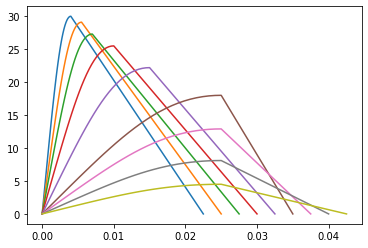

In [16]:
import ec2_fire_base as fire
df_conc = fire.df_conc

def fck_resid(maxtemp, df_conc, fck, agg='calc'):
    colname = 'kct_70' if fck >= 70 else 'kct_cal' if agg == 'calc' else 'kct_sil'
    
    phi = np.interp(maxtemp, df_conc.index, df_conc[colname])
    if fck < 70 and maxtemp > 100:
        phi *= (-0.00005*maxtemp + 1.05)

    return round(phi, 3)

def fck_temp(eps, maxtemp, df_conc, fck, agg='calc'):
    colname = 'kct_70' if fck >= 70 else 'kct_cal' if agg == 'calc' else 'kct_sil' 
    
    phi = np.interp(maxtemp, df_conc.index, df_conc[colname])      
    epsc1 = np.interp(maxtemp, df_conc.index, df_conc['eps1t'])
    epscu1 = np.interp(maxtemp, df_conc.index, df_conc['epsu1t'])

    if eps <= epsc1:
        sig = 3.0*eps*phi*fck / (2.0+math.pow(eps/epsc1, 3)) / epsc1
    elif eps < epscu1:
        sig = (1.0 - (eps-epsc1)/(epscu1-epsc1)) * phi * fck 
    else:
        sig = 0

    return round(sig, 3), phi * fck

def fck_temp_diag(maxtemp, df_conc, fck, agg='calc'):
    colname = 'kct_70' if fck >= 70 else 'kct_cal' if agg == 'calc' else 'kct_sil' 
    
    phi = np.interp(maxtemp, df_conc.index, df_conc[colname])*fck     
    epsc1 = np.interp(maxtemp, df_conc.index, df_conc['eps1t'])
    epscu1 = np.interp(maxtemp, df_conc.index, df_conc['epsu1t'])

    num = 30
    epsnp = np.linspace(0, epsc1, num=num)
    signp = np.zeros(num)
    aux1 = 3.0 / epsc1

    signp = epsnp * aux1 / (2.0+np.power(epsnp/epsc1, 3))
    #for i, x in enumerate(epsnp):
    #    signp[i] = x * aux1 / (2.0+math.pow(x/epsc1, 3))

    epsnp = np.append(epsnp, [epscu1])
    signp = np.append(signp, [0.0])
    return epsnp, signp * phi

import matplotlib.pyplot as plt
for i in range(1, 10):
    epsnp, signp = fck_temp_diag(i*100.0, df_conc, 30)
    plt.plot(epsnp, signp)

Index: [index](./ec2-fire-base.ipynb) | Next: [distance correction](./ec2-fire-tables.ipynb)